In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys; sys.path.append(os.path.abspath(os.path.join('..'))); sys.path.append(os.path.abspath(os.path.join('.')))
from modules.random_fields import GaussianRF_idct
from tools import ConfigManager
from utils.metrics import *
from utils.load import load_mnist
import time
import pickle

In [8]:
from modules.act_norm import ActNorm

In [9]:
cm = ConfigManager('../config.yaml')
cm.config['model']['name'] = "CouplingFlowAR"
car = cm.get_model().to('cuda')
total_params = sum(p.numel() for p in car.parameters())
print(f"Number of parameters: {total_params}")

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
car.load_state_dict(torch.load('../tmp/saved_ckpt/coupling_ar_epoch_19.pth'))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
def sample_grid(model, lowest, path=None, clip_range=None):
    plt.rcParams['figure.figsize'] = [8, 8]
    size_range = range(lowest, lowest+4*4, 4)
    for i, size in enumerate(size_range):
        plt.subplot(2, 2, i+1)
        plt.title(f'{size}x{size}')
        _sample_image_grid_from_model(model, resolution=size, device=torch.device('cuda'), clip_range=clip_range)
    if path is not None:
        plt.savefig(path)

@torch.no_grad()
def _sample_image_grid_from_model(model, device, resolution=28, clip_range=None):
    X_samples = model.sample(num_samples=4, resolution=resolution, device=device, a=2, lm=0.5, eps=0.001).cpu()
    if clip_range is not None:
        X_samples = torch.clamp(X_samples, clip_range[0], clip_range[1])
    print(X_samples.shape)
    grid = torchvision.utils.make_grid(X_samples, nrow=2)
    plt.imshow(grid[0], cmap="gray", vmin=0, vmax=255)

def test_sample_time(model, size_range):
    times = []
    for i, size in enumerate(size_range):
        start_time = time.time()
        _sample_image_grid_from_model(model, resolution=size, device=torch.device('cuda'))
        end_time = time.time()
        times.append(end_time - start_time)
    return times

In [ ]:
for i in car.flow:
    if isinstance(i, ActNorm):
        i.is_initialized = True
for i in car.ar_flow:
    if isinstance(i, ActNorm):
        i.is_initialized = True

/home/st813@ad.eng.cam.ac.uk/benchmark_iib/modules/filters.py:48: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  img = torch.fft.ifft2(F, norm='ortho').float()


torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 30, 30])
torch.Size([4, 1, 32, 32])
torch.Size([4, 1, 34, 34])
torch.Size([4, 1, 36, 36])
torch.Size([4, 1, 38, 38])
torch.Size([4, 1, 40, 40])
torch.Size([4, 1, 42, 42])
torch.Size([4, 1, 44, 44])
torch.Size([4, 1, 46, 46])
torch.Size([4, 1, 48, 48])
torch.Size([4, 1, 50, 50])
torch.Size([4, 1, 52, 52])
torch.Size([4, 1, 54, 54])
torch.Size([4, 1, 56, 56])


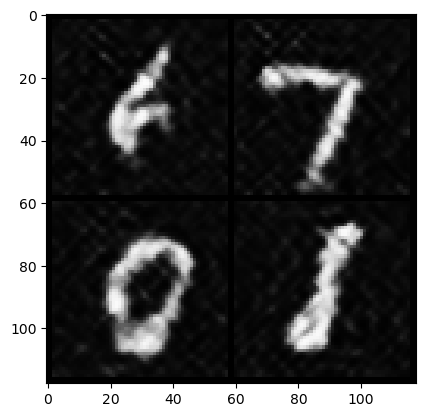

In [ ]:
times = test_sample_time(car, [28]+[2*i for i in range(14, 28)]+[56])
with open('car_time.pkl', 'wb') as f:
    pickle.dump(times, f)